In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import Callable, List

import Visualization_tools as sts
import Hamiltonian as ham
import MHMC as mh
import ProposalDistributions as PDs
#from Eggholder_Function_2 import EggholderLikelihood

import time

import matplotlib.colors as colors
from scipy.stats import poisson
from typing import Callable

In [3]:
class EggholderFunction:
    def __init__(self, a, b):
        self.a = a
        self.b = b
        self.bounds = [(-512, 512), (-512, 512)]

    def eggholder(self, x, y):
        fxy = -(y + self.a) * np.sin(np.sqrt(abs(x / self.b + (y + self.a)))) - x * np.sin(np.sqrt(abs(x - (y + self.a)))) + 1000
        return fxy

    def evaluate(self, params):
        x, y = params
        fxy = self.eggholder(x, y)
        return fxy

In [4]:
# Instantiate the EggholderLikelihood class
a=47
b=2
EHF = EggholderFunction(a,b)


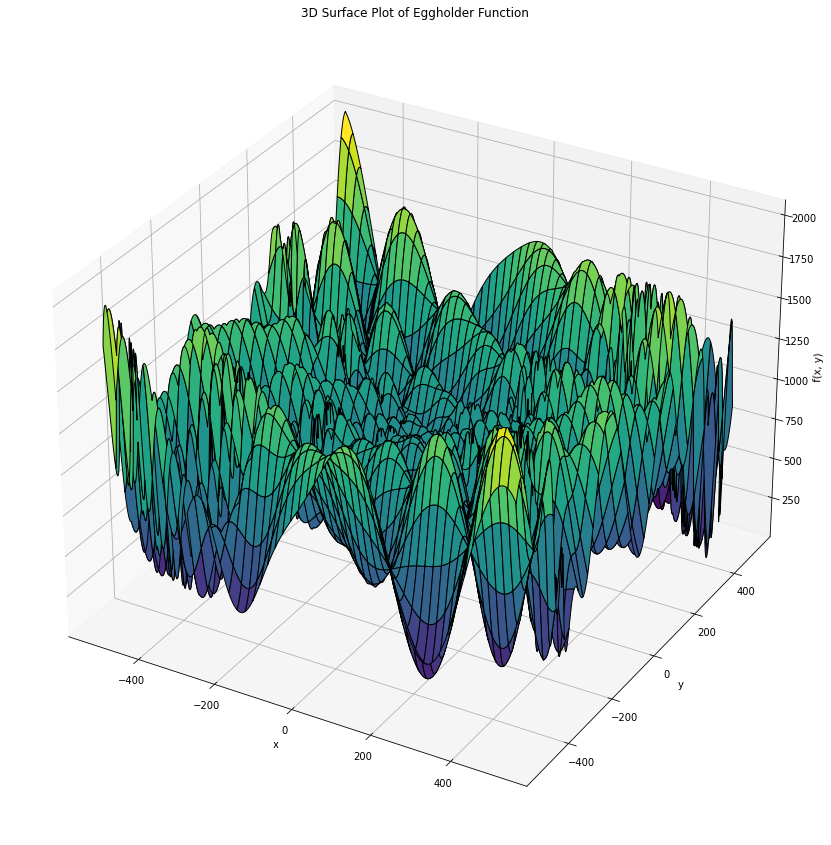

In [5]:
# Create an array of x and y values
N = 10000
x = np.linspace(-512, 512, N)
y = np.linspace(-512, 512, N)

# Create a grid of x and y values
x, y = np.meshgrid(x, y)

# Calculate the z values
z = EHF.eggholder(x, y)

# Create the plot
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='viridis', edgecolor='k')
ax.set_title('3D Surface Plot of Eggholder Function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
plt.show()

In [6]:
# Flatten z and normalize it
z_flat = z.flatten()
z_normalized = z_flat / np.sum(z_flat)

# Define indices
indices = np.arange(z_flat.size)

# Generate data indices according to the distribution of z
data_indices = np.random.choice(indices, size=N, p=z_normalized)

# Convert these indices back to 2D coordinates
data_coordinates = np.unravel_index(data_indices, z.shape)

# Extract the corresponding (x, y) data points
data = np.vstack((x[data_coordinates], y[data_coordinates])).T


Fake data

In [7]:
def generate_noisy_data(data, bins=30, noise_scale=None):
    '''
    Generate data with Asimov fluctuations
    
    Arguments
    data [np.ndarray]: initial dataset
    bins: number of bins for the Asimov fluctuation
    noise_scale: standard deviation of the Asimov noise
    
    Returns 
    noisy_data [np.ndarray or None]: data with the Asimov noise added
    
    '''
    n_dimensions = 2
    # First, create a numpy histogram
    data_hist, bin_edges = np.histogramdd(data, bins=bins)
    bin_centers = []
    for i in range(n_dimensions):
        bin_centers.append((bin_edges[i][:-1] + bin_edges[i][1:]) / 2.0)

    # Calculate the bin areas (assuming uniform bins)
    bin_areas = np.ones_like(data_hist)
    for i in range(n_dimensions):
        bin_areas *= (bin_edges[i][1:] - bin_edges[i][:-1]).reshape([-1 if j == i else 1 for j in range(n_dimensions)])

    # Calculate expected number of events per bin and add Asimov fluctuations
    expected_values = data_hist * bin_areas
    asimov_fluctuations = np.random.normal(expected_values, np.sqrt(expected_values))
    noisy_data_hist = asimov_fluctuations

    # Create the noisy dataset with the same size as the original data
    noisy_data = np.empty_like(data)
    for i in range(n_dimensions):
        noisy_data[:, i] = np.random.choice(bin_centers[i], size=data.shape[0], p=sum(noisy_data_hist / noisy_data_hist.sum()))

    if noise_scale is not None:
        noisy_data = noisy_data + np.random.normal(scale=noise_scale, size=noisy_data.shape)

    return noisy_data


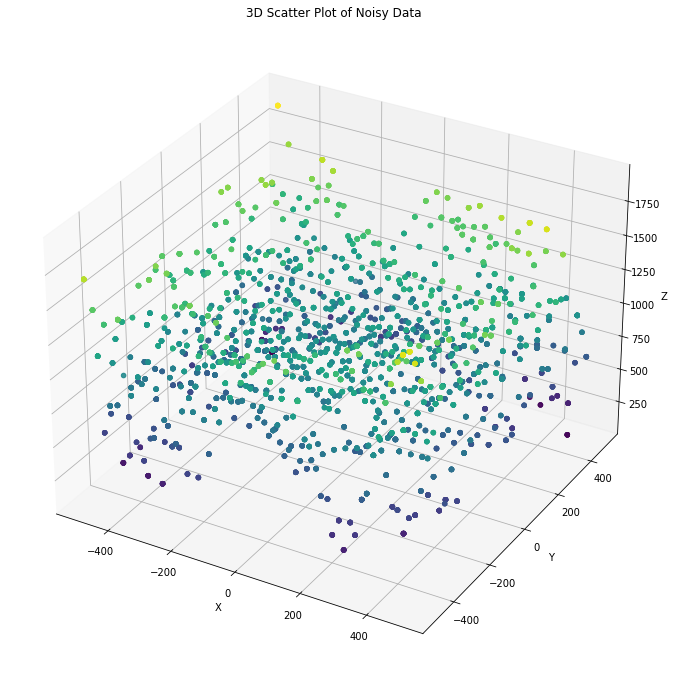

In [8]:
# Generate the noisy data
noisy_data = generate_noisy_data(data=data, bins=30)

# Extract the x, y, z coordinates from the noisy data
x_noisy = noisy_data[:, 0]
y_noisy = noisy_data[:, 1]
z_noisy = EHF.evaluate(noisy_data.T)  # Evaluate the Eggholder function for the noisy data

# Create the 3D scatter plot
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_noisy, y_noisy, z_noisy, c=z_noisy, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot of Noisy Data')
plt.show()


Heatmap

In [9]:
def plot_heatmap(noisy_data):
    a, b = EHF.bounds
    x = np.linspace(a[0], a[1], 400)
    y = np.linspace(b[0], b[1], 400)
    X, Y = np.meshgrid(x, y)
    Z = EHF.eggholder(X, Y)

    plt.figure(figsize=(15, 12))
    plt.imshow(Z, cmap='viridis', extent=[a[0], a[1], b[0], b[1]], origin='lower')

    plt.colorbar(label='f(x, y)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('2D Heatmap of Eggholder Function with Noisy Data')
    plt.legend()
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


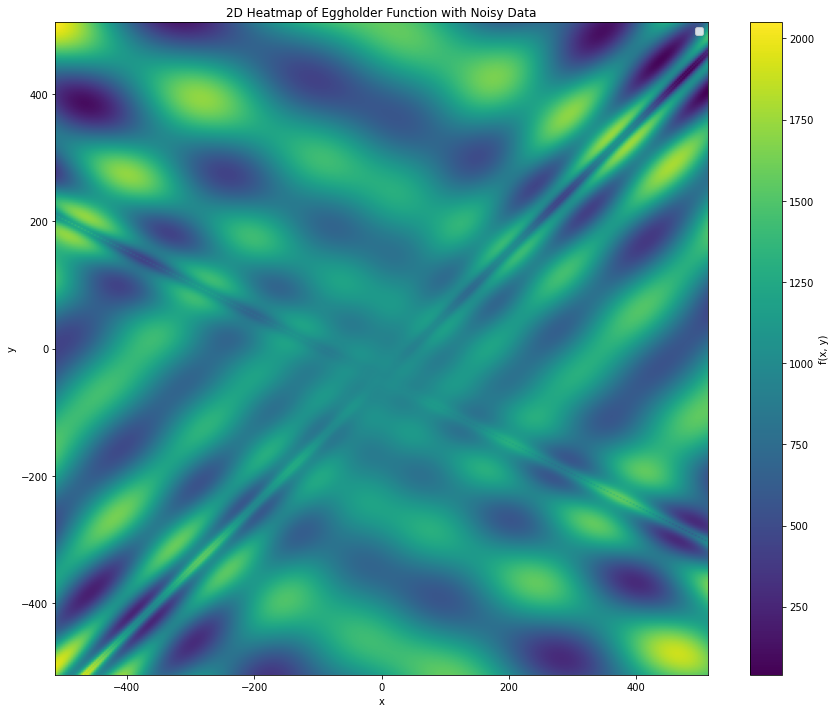

In [10]:
plot_heatmap(noisy_data)


Histograms

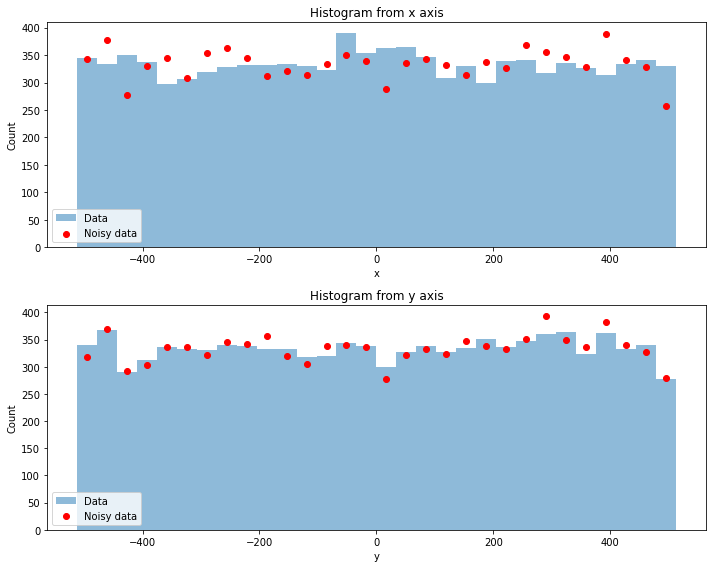

In [11]:

# Extract the x and y dimensions from the noisy data
# x_data = data[:,0]
# y_data = data[:,1]

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(10,8))

# Plot the histogram for the x dimension

for i in range(2):
    data_counts, data_edges = np.histogram(data[:,i], bins=30)
    data_bin_centers = (data_edges[:-1] + data_edges[1:]) / 2.0
    noisy_counts, noisy_edges = np.histogram(noisy_data[:,i], bins=30)
    noisy_bin_centers = (noisy_edges[:-1] + noisy_edges[1:]) / 2.0
    data_bars = axs[i].bar(data_bin_centers, data_counts, alpha=0.5, label='Data', width=(data_bin_centers[1] - data_bin_centers[0]))
    noisy_points = axs[i].scatter(data_bin_centers, noisy_counts, color='red', label='Noisy data')
    handles = [data_bars, noisy_points]
    if i == 0:
        axs[i].set_title('Histogram from x axis')
        axs[i].set_xlabel('x')
        axs[i].set_ylabel('Count')
        axs[i].legend(handles=handles,loc=3)
    if i == 1:
        axs[i].set_title('Histogram from y axis')
        axs[i].set_xlabel('y')
        axs[i].set_ylabel('Count')
        axs[i].legend(handles=handles,loc=3)

# Display the figure
plt.tight_layout()
plt.show()


Log likelihood

In [18]:

def log_likelihood(x, y, mcx, mcy, a, b):
    lambda_ = EHF.eggholder(x, y,a,b)  
    data = EHF.eggholder(mcx, mcy,a,b)  
    log_likelihood_value = -(lambda_ - data + data * np.log(data/lambda_))
    return log_likelihood_value

def log_likelihoods(params):
    a, b = params
    return np.sum(log_likelihood(x=data[:,0], 
                                 y=data[:,1], 
                                 mcx=noisy_data[:,0], 
                                 mcy=noisy_data[:,1], 
                                 a=a, 
                                 b=b))


In [19]:
def dfdx(mu):
    '''
    Forward differencing scheme
    '''
    epsilon = 0.01
    n_dims = 1
    n_comp = 1
    mu = np.array(mu)
    delta_theta = []
    res_mu_plus = []
    for i in range(mu.shape[0]):
        E_plus = np.zeros(n_dims*n_comp)
        E_plus += [(epsilon if j == i else 0) for j in range(n_dims*n_comp)]
        res_mu_plus.append(E_plus)

    for i in range(n_dims*n_comp):
        delta_thetai = (log_likelihoods(mu+res_mu_plus[i]) - log_likelihoods(mu))/(epsilon)
        delta_theta.append(delta_thetai)
        
    return delta_theta

In [20]:
def U(theta: List[np.longdouble]) -> np.longdouble:
    '''
    the potential energy function: 
    U(theta) = -log(probability distribution of theta)
    '''
    return - log_likelihoods(theta)

def grad_U(theta: List[np.longdouble]) -> np.longdouble:
    '''
    the derivative of the eggholder function
    dU/dmu
    '''
    DRho = dfdx(theta)
    Rho = - log_likelihoods(theta)
    return np.array([dRho/Rho for dRho in DRho])

MHMC

In [ ]:
steps = 100000
sd=1000
Prop_G = PDs.GaussianProposalDistribution(sd=sd, Dim=2)
MHMC_EHF = mh.MHMC(rho=EHF.evaluate, log_likelihood=False)  # Pass the evaluate method of the EHF instance
Res_G_EHF = mh.MHMC_EHF.generate(
    theta0=[-1.0 for _ in range(2)], 
    qProb=Prop_G.log_qProb, 
    qSamp=Prop_G.qSample, 
    steps=steps,
    OutputRunTime=100,
    MaxTime=100
)

In [ ]:
# density_plot_3D

sts.density_plots(
    Res_G_EHF["Thetas"], 
    bins=30,
    burn_in=1000,
    plot_axis=[0, 1],
    axis_name=["a", "b"]
)

In [ ]:
# Iterate over the results
for Res in [Res_G_EHF]:
    with plt.style.context("ggplot"):
        plt.plot([100*i for i in range(1, len(Res["Run_Times"])+1)], Res["Run_Times"])
        plt.ylabel("Time taken (seconds)", fontsize=18)
        plt.yticks(fontsize=18)
        plt.xticks(rotation=45)
        plt.xlabel("Step", fontsize=18)
        plt.xticks(fontsize=18)
        plt.show()


In [ ]:
# densities_plot

from Statistic_tools import densities_plot

Res = Res_G_EHF

for bi, Res in zip([1000], [Res_G_EHF]):
    _ = densities_plot(Thetas=Res["Thetas"], plot_axis=[], bins=50, burn_in=bi, cr_1D=0.9)
    
    

In [ ]:
for Res, MC_name in zip([Res_G_EHF], ["MHMCMC"]):
    print(f"The acceptance rate of the MCMC algorithm = {Res['Acceptance_Rate']:.3f}")
    steps = Res["Thetas"].shape[0]
    with plt.style.context("ggplot"):
        plt.figure(figsize=(8, 8))
        plt.title(f"Parameter Samples - {MC_name}")
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.scatter(Res["Thetas"][:steps//2, 0], Res["Thetas"][:steps//2, 1], label=f"First half output of {MC_name}")
        plt.scatter(Res["Thetas"][steps//2:, 0], Res["Thetas"][steps//2:, 1], label=f"Second half output of {MC_name}")
        plt.scatter(0, 0, label="True Value", color="black")
        plt.legend()
        plt.show()


In [ ]:
sts.targetDis_step_plot(Thetas=Res_G_EHF["Thetas"], rho=EHF.evaluate, target_type="likelihood function", burn_in=0)


In [ ]:
sts.auto_corr_plot(Thetas=Res_G_EHF["Thetas"], plot_nth_theta=[0,1], theta_index=["X", "Y"], max_time_lag=9000, data_range=[1000, 40000])

HMC

In [ ]:
theta_accept, theta_reject = ham.HMC(epoch=1000, 
                                 L=30, 
                                 epsilon=0.05, 
                                 U=U, 
                                 grad_U=grad_U, 
                                 current_theta=np.array([0,0]))

In [ ]:
sts.auto_corr_plot(theta_accept, 
                   plot_nth_theta=[0, 1], 
                   theta_index=['$a$', '$b$'], 
                   max_time_lag=len(theta_accept), 
                   figsize=[8, 6])


In [ ]:
a = np.linspace(0, 60, 100)
b = np.linspace(0, 60, 100)
a, b = np.meshgrid(a, b)

Z = np.zeros([100, 100])
for i in range(100):
    for j in range(100):
        Z[i][j] = log_likelihoods([a[i][j], b[i][j]])

Z1 = []
for i in range(len(theta_accept)):
    Z1.append(log_likelihoods([theta_accept[i][0], theta_accept[i][1]]))


In [ ]:
plt.figure(figsize=(12, 10))


# Scatter plot of the sampled points
plt.scatter(np.array(theta_accept)[:, 0], np.array(theta_accept)[:, 1], marker='x', color='red', label='Accepted Points')

# Plot the trace of the sampled points
plt.plot(np.array(theta_accept)[:, 0], np.array(theta_accept)[:, 1], '--', color='orange', label='Trace')

# Add the true value point
plt.scatter(47, 2, color='black', label='True Value', marker='o')

# Mark the start and end points
plt.scatter(np.array(theta_accept)[0, 0], np.array(theta_accept)[0, 1], color='green', label='Start Point', marker='s')
plt.scatter(np.array(theta_accept)[-1, 0], np.array(theta_accept)[-1, 1], color='blue', label='End Point', marker='^')

plt.xlabel('$a$')
plt.ylabel('$b$')
plt.legend()
plt.title('Trace of sampled points')
plt.show()


In [ ]:
sts.density_plots(Thetas=np.array(theta_accept), 
                  plot_axis=[], 
                  bins=30, 
                  burn_in=0, 
                  cr_1D=0.9,
                  axis_name=["a", "b"])

In [ ]:
fig = plt.figure(figsize=(8, 8), facecolor="white")
ax = fig.add_subplot(projection='3d')

ax.plot_surface(a,b,Z,alpha=0.7,cmap='coolwarm',label='logLikelihood')

ax.set_xlabel('$a$')
ax.set_ylabel('$b$')
ax.set_zlabel('LogLikelihood')

ax.plot(np.array(theta_accept)[:,0],np.array(theta_accept)[:,1],Z1,'x',color='red',label='Accepted points')

plt.show()